In [12]:
!apt-get install -y libspatialindex-dev
!pip install rasterio geopandas rioxarray scikit-image folium hdbscan umap-learn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libspatialindex-dev is already the newest version (1.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [13]:
import rasterio, geopandas, sklearn, matplotlib, folium
print("Setup OK")


Setup OK


In [14]:
!wget -O sample_satellite.tif https://raw.githubusercontent.com/rasterio/rasterio/main/tests/data/RGB.byte.tif


--2026-02-12 16:31:03--  https://raw.githubusercontent.com/rasterio/rasterio/main/tests/data/RGB.byte.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1745956 (1.7M) [image/tiff]
Saving to: ‘sample_satellite.tif’

sample_satellite.ti 100%[===================>]   1.67M  --.-KB/s    in 0.06s   

2026-02-12 16:31:03 (29.2 MB/s) - ‘sample_satellite.tif’ saved [1745956/1745956]



Image shape (bands, height, width): 3 718 791
CRS: EPSG:32618


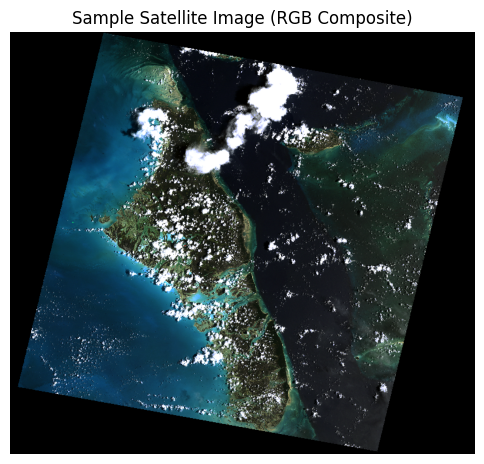

In [15]:
import rasterio
import matplotlib.pyplot as plt

# Open image
src = rasterio.open("sample_satellite.tif")
print("Image shape (bands, height, width):", src.count, src.height, src.width)
print("CRS:", src.crs)

img = src.read()

# Plot RGB composite
plt.figure(figsize=(6,6))
plt.imshow(img.transpose(1,2,0))
plt.title("Sample Satellite Image (RGB Composite)")
plt.axis("off")
plt.show()


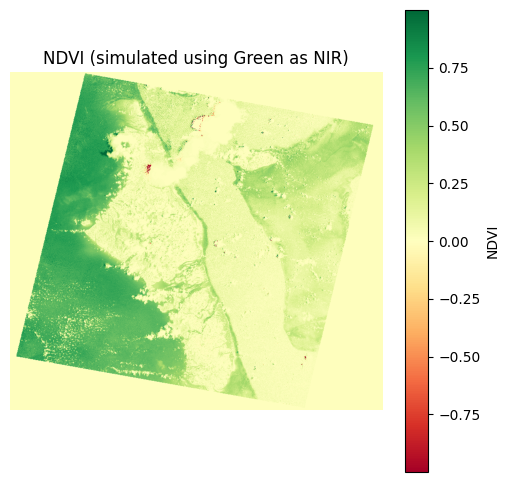

In [16]:
import numpy as np

# Read bands: our test image has 3 bands (R=1, G=2, B=3)
red = src.read(1).astype(float)
green = src.read(2).astype(float)  # we simulate NIR with green for now

# NDVI formula
ndvi = (green - red) / (green + red + 1e-5)  # add epsilon to avoid /0

# Plot NDVI
plt.figure(figsize=(6,6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label="NDVI")
plt.title("NDVI (simulated using Green as NIR)")
plt.axis("off")
plt.show()



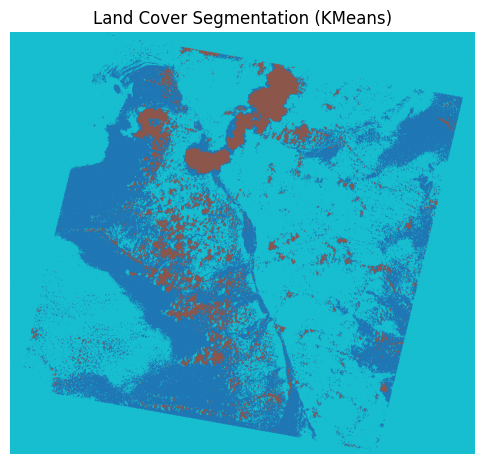

In [17]:
from sklearn.cluster import KMeans

# Stack bands into feature space
# (height*width, bands)
h, w = red.shape
X = np.stack([red.ravel(), green.ravel()], axis=1)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# Reshape back to image
labels_img = labels.reshape(h, w)

# Plot segmented map
plt.figure(figsize=(6,6))
plt.imshow(labels_img, cmap='tab10')
plt.title("Land Cover Segmentation (KMeans)")
plt.axis("off")
plt.show()

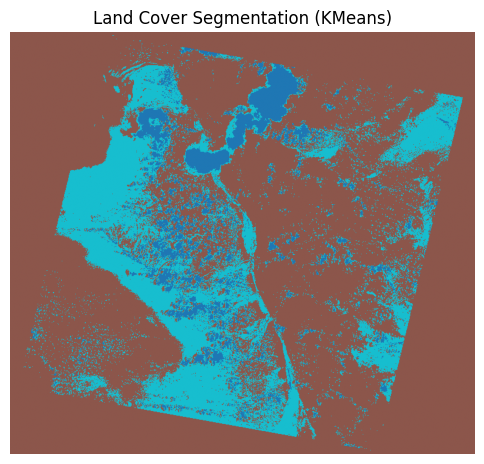

In [18]:

from sklearn.cluster import KMeans

# Stack pixel features
h, w = red.shape
X = np.stack([red.ravel(), green.ravel()], axis=1)

# Run KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Reshape back to image
labels_img = labels.reshape(h, w)

# Plot land cover segmentation
plt.figure(figsize=(6,6))
plt.imshow(labels_img, cmap="tab10")
plt.title("Land Cover Segmentation (KMeans)")
plt.axis("off")
plt.show()

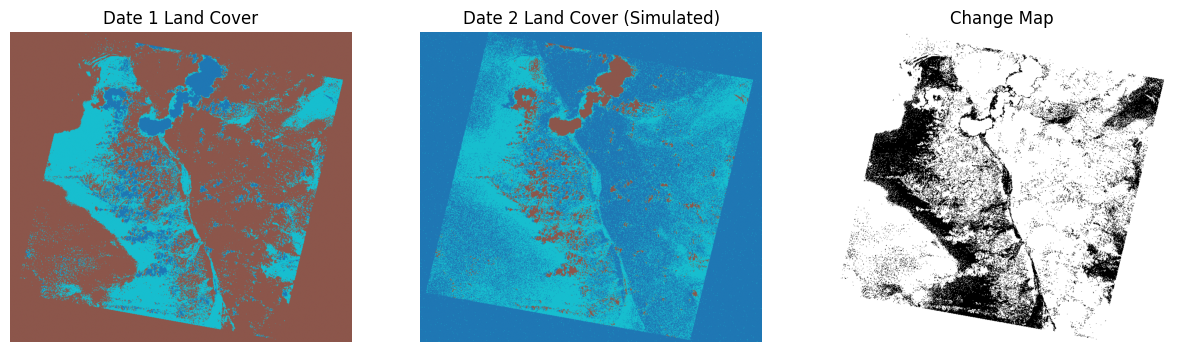

In [19]:

import numpy as np

# Date 1 segmentation (already computed)
labels_date1 = labels_img

# Simulate Date 2 by adding noise (like environmental changes)
X_noisy = X + np.random.normal(0, 20, X.shape)  # add noise to pixel features
labels_date2 = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_noisy).reshape(h, w)

# Compute change map (where labels differ)
change_map = (labels_date1 != labels_date2).astype(int)

# --- Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].imshow(labels_date1, cmap="tab10")
axs[0].set_title("Date 1 Land Cover")
axs[0].axis("off")

axs[1].imshow(labels_date2, cmap="tab10")
axs[1].set_title("Date 2 Land Cover (Simulated)")
axs[1].axis("off")

axs[2].imshow(change_map, cmap="gray")
axs[2].set_title("Change Map")
axs[2].axis("off")

plt.show()


In [20]:
import ee

# Authenticate (only once per session, will ask you for a link & token)
ee.Authenticate()

# Replace with your own Google Cloud Project ID (the one you enabled Earth Engine API on)
PROJECT = "gee-change-detection-471218"

# Initialize with project
ee.Initialize(project=PROJECT)

print("✅ Earth Engine is ready in Colab with project:", PROJECT)


✅ Earth Engine is ready in Colab with project: gee-change-detection-471218


In [21]:
#
# User Inputs

roi = ee.Geometry.Rectangle([76.9, 28.4, 77.4, 28.9])  # Example: Delhi

# Dates to compare
start_date_1 = "2023-01-01"
end_date_1   = "2023-03-31"
start_date_2 = "2025-01-01"
end_date_2   = "2025-03-31"

# Sampling + scale
SAMPLE_PIXELS = 5000
SCALE = 10  # Sentinel-2 native resolution

# NDVI thresholds
LOSS_THRESHOLD = -0.1
GAIN_THRESHOLD = 0.1
# ================================

# U can change dimensions to check any place just change this as your requirements:
# roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
# start_date_1 = "YYYY-MM-DD"
# end_date_1   = "YYYY-MM-DD"
# start_date_2 = "YYYY-MM-DD"
# end_date_2   = "YYYY-MM-DD"

In [22]:
import ee
import geemap

# Use the project you already set up
PROJECT = "gee-change-detection-471218"
ee.Initialize(project=PROJECT)

# Define a location (e.g., New Delhi bounding box)
roi = ee.Geometry.Rectangle([77.1, 28.55, 77.3, 28.75])  # small patch in Delhi

# Load Sentinel-2 surface reflectance collection
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(roi) \
    .filterDate(start_date_1, end_date_1) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))

# Take median image of the month
image_2022 = collection.median().clip(roi)

# Repeat for 2024
collection2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(roi) \
    .filterDate(start_date_2, end_date_2) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))

image_2024 = collection2.median().clip(roi)

# Visualization params (RGB bands)
vis_params = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}

# Create interactive map
Map = geemap.Map()
Map.centerObject(roi, 12)
Map.addLayer(image_2022, vis_params, "Delhi 2022")
Map.addLayer(image_2024, vis_params, "Delhi 2024")
Map.addLayer(roi, {}, "ROI")
Map


Map(center=[28.6500049322589, 77.19999999999995], controls=(WidgetControl(options=['position', 'transparent_bg…

In [23]:
# Make ROI a bit bigger (Delhi region)
roi = ee.Geometry.Rectangle([76.9, 28.4, 77.4, 28.9])

# Reload Sentinel-2 with bigger date range
collection_2022 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(roi) \
    .filterDate(start_date_1, end_date_1) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))

image_2022 = collection_2022.median().clip(roi)

collection_2024 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(roi) \
    .filterDate(start_date_2, end_date_2) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))

image_2024 = collection_2024.median().clip(roi)

# Double check available bands
print("Bands in 2022 image:", image_2022.bandNames().getInfo())
print("Bands in 2024 image:", image_2024.bandNames().getInfo())

Bands in 2022 image: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']
Bands in 2024 image: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [24]:
# Function to calculate NDVI
def add_ndvi(image):
    return image.normalizedDifference(["B8", "B4"]).rename("NDVI")

# Compute NDVI for both years
ndvi_2022 = add_ndvi(image_2022)
ndvi_2024 = add_ndvi(image_2024)

# NDVI change (2024 - 2022)
ndvi_diff = ndvi_2024.subtract(ndvi_2022).rename("NDVI Change")

# Visualization parameters
ndvi_params = {"min": 0, "max": 1, "palette": ["brown", "yellow", "green"]}
diff_params = {"min": -0.5, "max": 0.5, "palette": ["red", "white", "green"]}

# Display on interactive map
Map = geemap.Map()
Map.centerObject(roi, 12)
Map.addLayer(ndvi_2022, ndvi_params, "NDVI 2022")
Map.addLayer(ndvi_2024, ndvi_params, "NDVI 2024")
Map.addLayer(ndvi_diff, diff_params, "NDVI Change (2024-2022)")
Map.addLayer(roi, {}, "ROI")
Map

Map(center=[28.65003081991171, 77.14999999999954], controls=(WidgetControl(options=['position', 'transparent_b…

In [25]:
# 2023 Image (Jan–Mar)
collection_2023 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(roi) \
    .filterDate(start_date_1, end_date_1) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))

image_2023 = collection_2023.median().clip(roi)

# 2025 Image (Jan–Mar)
collection_2025 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(roi) \
    .filterDate(start_date_2, end_date_2) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))

image_2025 = collection_2025.median().clip(roi)

# Sanity check: bands available
print("Bands in 2023 image:", image_2023.bandNames().getInfo())
print("Bands in 2025 image:", image_2025.bandNames().getInfo())

Bands in 2023 image: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']
Bands in 2025 image: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [26]:
bands_2023 = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12',
              'AOT','WVP','SCL','TCI_R','TCI_G','TCI_B','MSK_CLDPRB','MSK_SNWPRB',
              'QA10','QA20','QA60']

bands_2025 = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12',
              'AOT','WVP','SCL','TCI_R','TCI_G','TCI_B','MSK_CLDPRB','MSK_SNWPRB',
              'MSK_CLASSI_OPAQUE','MSK_CLASSI_CIRRUS','MSK_CLASSI_SNOW_ICE']

# Intersection (common bands only)
common_bands = list(set(bands_2023) & set(bands_2025))
common_bands.sort()
print(common_bands)


['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLDPRB', 'MSK_SNWPRB', 'SCL', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP']


In [27]:

# Select only the common bands
image_2023 = image_2023.select(common_bands)
image_2025 = image_2025.select(common_bands)

# Now compute difference
change = image_2025.subtract(image_2023)


In [28]:
# 1️⃣ Load Sentinel-2 surface reflectance images
image_2023 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate(start_date_1, end_date_1) \
    .filterBounds(roi) \
    .median()

image_2025 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate(start_date_2, end_date_2) \
    .filterBounds(roi) \
    .median()

# 2️⃣ Get available bands (convert to Python lists)
bands_2023 = image_2023.bandNames().getInfo()
bands_2025 = image_2025.bandNames().getInfo()

# 3️⃣ Compute intersection in Python
common_bands = list(set(bands_2023) & set(bands_2025))
common_bands.sort()

print("Common bands:", common_bands)

# 4️⃣ Select only common bands
image_2023 = image_2023.select(common_bands)
image_2025 = image_2025.select(common_bands)

# 5️⃣ Compute change (difference)
change = image_2025.subtract(image_2023)

# 6️⃣ Visualization
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}

Map = geemap.Map()
Map.centerObject(roi, 10)
Map.addLayer(image_2023, vis_params, "2023 Composite")
Map.addLayer(image_2025, vis_params, "2025 Composite")
Map.addLayer(change.select(['B4','B3','B2']), {'min': -1000, 'max': 1000}, "Change 2023-2025")
Map


Common bands: ['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_SNOW_ICE', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'SCL', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP']


Map(center=[28.65003081991171, 77.14999999999954], controls=(WidgetControl(options=['position', 'transparent_b…

In [29]:
# 1️⃣ Load Sentinel-2 (already harmonized)
image_2023 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate(start_date_1, end_date_1) \
    .filterBounds(roi) \
    .median()

image_2025 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate(start_date_2, end_date_2) \
    .filterBounds(roi) \
    .median()

# 2️⃣ Compute NDVI = (B8 - B4) / (B8 + B4)
def compute_ndvi(img):
    return img.normalizedDifference(["B8", "B4"]).rename("NDVI")

ndvi_2023 = compute_ndvi(image_2023)
ndvi_2025 = compute_ndvi(image_2025)

# 3️⃣ NDVI change (2025 - 2023)
ndvi_change = ndvi_2025.subtract(ndvi_2023).rename("NDVI Change")

# 4️⃣ Visualization parameters
ndvi_params = {"min": 0, "max": 1, "palette": ["brown", "yellow", "green"]}
change_params = {"min": -0.5, "max": 0.5, "palette": ["red", "white", "green"]}

# 5️⃣ Display on map
Map = geemap.Map()
Map.centerObject(roi, 10)
Map.addLayer(ndvi_2023, ndvi_params, "NDVI 2023")
Map.addLayer(ndvi_2025, ndvi_params, "NDVI 2025")
Map.addLayer(ndvi_change, change_params, "NDVI Change (2025-2023)")
Map


Map(center=[28.65003081991171, 77.14999999999954], controls=(WidgetControl(options=['position', 'transparent_b…

In [30]:
# Thresholds for change (you can adjust)
loss_threshold = -0.1   # NDVI decrease greater than this = vegetation loss
gain_threshold = 0.1    # NDVI increase greater than this = vegetation gain

# Classify change
loss = ndvi_change.lt(loss_threshold)   # pixels with loss
gain = ndvi_change.gt(gain_threshold)   # pixels with gain
stable = ndvi_change.gte(loss_threshold).And(ndvi_change.lte(gain_threshold))

# Count pixels in each class
total_pixels = ndvi_change.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=roi,
    scale=10,    # Sentinel-2 resolution
    maxPixels=1e10
).get("NDVI Change")

loss_pixels = loss.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    maxPixels=1e10
).get("NDVI Change")

gain_pixels = gain.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    maxPixels=1e10
).get("NDVI Change")

stable_pixels = stable.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    maxPixels=1e10
).get("NDVI Change")

# Get values into Python
total = ee.Number(total_pixels).getInfo()
loss_val = ee.Number(loss_pixels).getInfo()
gain_val = ee.Number(gain_pixels).getInfo()
stable_val = ee.Number(stable_pixels).getInfo()

# Compute percentages
loss_pct = (loss_val / total) * 100
gain_pct = (gain_val / total) * 100
stable_pct = (stable_val / total) * 100

print("🌱 Vegetation Change Report (2023 → 2025)")
print(f"Vegetation Loss : {loss_val} pixels ({loss_pct:.2f}%)")
print(f"Vegetation Gain : {gain_val} pixels ({gain_pct:.2f}%)")
print(f"Stable Vegetation : {stable_val} pixels ({stable_pct:.2f}%)")
print(f"Total Pixels : {total}")


🌱 Vegetation Change Report (2023 → 2025)
Vegetation Loss : 3248987.8509803917 pixels (10.49%)
Vegetation Gain : 6238479.996078432 pixels (20.14%)
Stable Vegetation : 21492686.384313658 pixels (69.38%)
Total Pixels : 30980356


In [31]:
# Export NDVI Change map to Google Drive
task = ee.batch.Export.image.toDrive(
    image=ndvi_change,
    description='NDVI_Change_2023_2025',
    folder='EarthEngine',
    fileNamePrefix='NDVI_Change_2023_2025',
    scale=10,
    region=roi,
    maxPixels=1e13
)
task.start()
print("Export started – check Google Drive > EarthEngine folder")


Export started – check Google Drive > EarthEngine folder


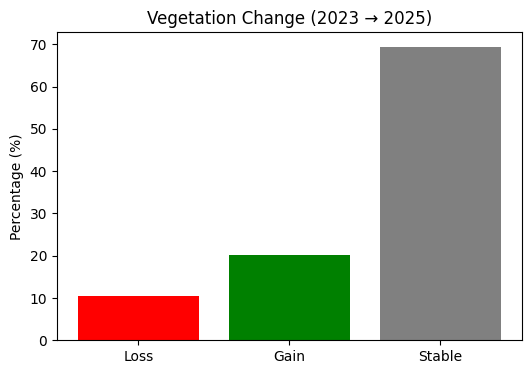

In [32]:

import matplotlib.pyplot as plt

categories = ["Loss", "Gain", "Stable"]
percentages = [loss_pct, gain_pct, stable_pct]

plt.figure(figsize=(6,4))
plt.bar(categories, percentages, color=["red","green","gray"])
plt.ylabel("Percentage (%)")
plt.title("Vegetation Change (2023 → 2025)")
plt.show()


In [33]:
# Extract NDVI pixel values as arrays
rect_2023 = ndvi_2023.sampleRectangle(region=roi, defaultValue=0)
rect_2025 = ndvi_2025.sampleRectangle(region=roi, defaultValue=0)

# Get values into Python
ndvi_arr_2023 = np.array(rect_2023.get('NDVI').getInfo())
ndvi_arr_2025 = np.array(rect_2025.get('NDVI').getInfo())

print("NDVI 2023 shape:", ndvi_arr_2023.shape)
print("NDVI 2025 shape:", ndvi_arr_2025.shape)


NDVI 2023 shape: (1, 2)
NDVI 2025 shape: (1, 2)


In [34]:
# Expand ROI slightly (buffer by 5 km)
roi_large = roi.buffer(5000)

# Sample NDVI with coarser resolution (~100m instead of 10m)
rect_2023 = ndvi_2023.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi_large,
    scale=100,
    maxPixels=1e8
)

rect_2025 = ndvi_2025.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi_large,
    scale=100,
    maxPixels=1e8
)

# Convert to NumPy
ndvi_arr_2023 = np.array(rect_2023.get('NDVI').getInfo())
ndvi_arr_2025 = np.array(rect_2025.get('NDVI').getInfo())

print("NDVI 2023 pixels:", len(ndvi_arr_2023))
print("NDVI 2025 pixels:", len(ndvi_arr_2025))


NDVI 2023 pixels: 437158
NDVI 2025 pixels: 437158


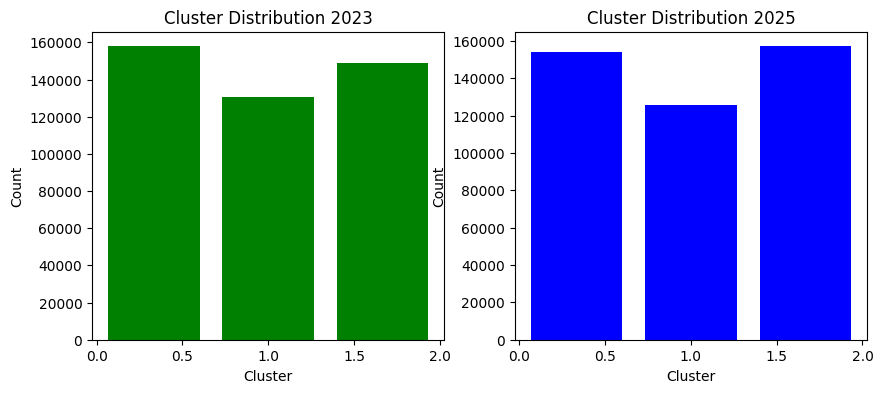

In [35]:
# Convert lists into NumPy arrays (reshape for sklearn)
X_2023 = np.array(ndvi_arr_2023).reshape(-1, 1)
X_2025 = np.array(ndvi_arr_2025).reshape(-1, 1)

# Run KMeans (3 clusters = low, medium, high vegetation)
kmeans_2023 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_2023)
kmeans_2025 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_2025)

# Cluster labels
labels_2023 = kmeans_2023.labels_
labels_2025 = kmeans_2025.labels_

# Quick visualization: histogram of NDVI cluster distribution
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(labels_2023, bins=3, color="green", rwidth=0.8)
plt.title("Cluster Distribution 2023")
plt.xlabel("Cluster"); plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(labels_2025, bins=3, color="blue", rwidth=0.8)
plt.title("Cluster Distribution 2025")
plt.xlabel("Cluster"); plt.ylabel("Count")

plt.show()

In [36]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Align both years' cluster labels (they already have same length: 437,158 pixels)
transitions = confusion_matrix(labels_2023, labels_2025)

# Put in a DataFrame for readability
df_transitions = pd.DataFrame(
    transitions,
    index=[f"2023_C{i}" for i in range(3)],
    columns=[f"2025_C{i}" for i in range(3)]
)

print("🌱 Vegetation Cluster Transition Matrix (2023 → 2025)")
print(df_transitions)

🌱 Vegetation Cluster Transition Matrix (2023 → 2025)
         2025_C0  2025_C1  2025_C2
2023_C0   136186     1147    20510
2023_C1     2909   100005    27736
2023_C2    15235    24549   108881


In [37]:
df_transitions_pct = df_transitions.div(df_transitions.sum(axis=1), axis=0) * 100
print("\n🌱 Transition Matrix in % (row-normalized)")
print(df_transitions_pct.round(2))



🌱 Transition Matrix in % (row-normalized)
         2025_C0  2025_C1  2025_C2
2023_C0    86.28     0.73    12.99
2023_C1     2.23    76.54    21.23
2023_C2    10.25    16.51    73.24


Sample sizes -> 2023: 5000   2025: 5000


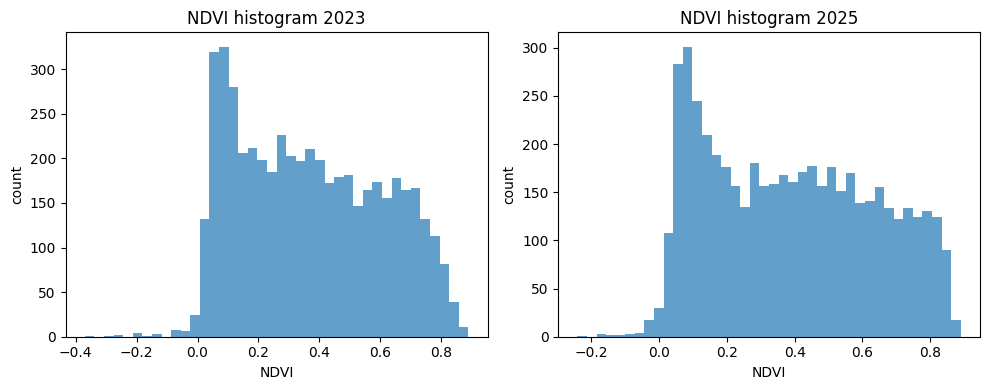

In [38]:
import ee, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Parameters (adjust SAMPLE_PIXELS if needed)
SAMPLE_PIXELS = 5000
SCALE = 10   # Sentinel-2 native 10m band resolution

# Sample NDVI from the EE ndvi images (ndvi_2023 and ndvi_2025 must exist in the notebook)
fc_2023 = ndvi_2023.sample(region=roi, scale=SCALE, numPixels=SAMPLE_PIXELS, seed=42)
fc_2025 = ndvi_2025.sample(region=roi, scale=SCALE, numPixels=SAMPLE_PIXELS, seed=43)

# Pull small FeatureCollections to the client
info_2023 = fc_2023.select('NDVI').getInfo()
info_2025 = fc_2025.select('NDVI').getInfo()

# Helper: extract NDVI values safely
def extract_ndvi_from_fc(info):
    feats = info.get('features', [])
    vals = []
    for f in feats:
        props = f.get('properties', {})
        v = props.get('NDVI')
        if v is not None:
            vals.append(float(v))
    return np.array(vals, dtype=float)

vals_2023 = extract_ndvi_from_fc(info_2023)
vals_2025 = extract_ndvi_from_fc(info_2025)

print("Sample sizes -> 2023:", vals_2023.size, "  2025:", vals_2025.size)

# Quick sanity plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(vals_2023, bins=40, alpha=0.7)
plt.title("NDVI histogram 2023")
plt.xlabel("NDVI"); plt.ylabel("count")
plt.subplot(1,2,2)
plt.hist(vals_2025, bins=40, alpha=0.7)
plt.title("NDVI histogram 2025")
plt.xlabel("NDVI"); plt.ylabel("count")
plt.tight_layout()
plt.show()
# ----------------------------------


In [39]:
from sklearn.cluster import KMeans

# Stack both years' NDVI values so clustering is consistent
X = np.concatenate([vals_2023, vals_2025]).reshape(-1, 1)

# Run KMeans with 3 clusters (low, medium, high vegetation)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)

# Predict cluster assignments separately for 2023 and 2025
labels_2023 = kmeans.predict(vals_2023.reshape(-1, 1))
labels_2025 = kmeans.predict(vals_2025.reshape(-1, 1))

# Calculate % distribution in each cluster
dist_2023 = pd.Series(labels_2023).value_counts(normalize=True).sort_index() * 100
dist_2025 = pd.Series(labels_2025).value_counts(normalize=True).sort_index() * 100

# Make a nice table
cluster_table = pd.DataFrame({
    "Cluster Center (NDVI)": kmeans.cluster_centers_.flatten(),
    "2023 %": dist_2023.values,
    "2025 %": dist_2025.values
}).sort_values("Cluster Center (NDVI)")

cluster_table


,Cluster Center (NDVI),2023 %,2025 %
0,0.122796,38.08,36.48
1,0.395865,34.18,33.02
2,0.684816,27.74,30.50


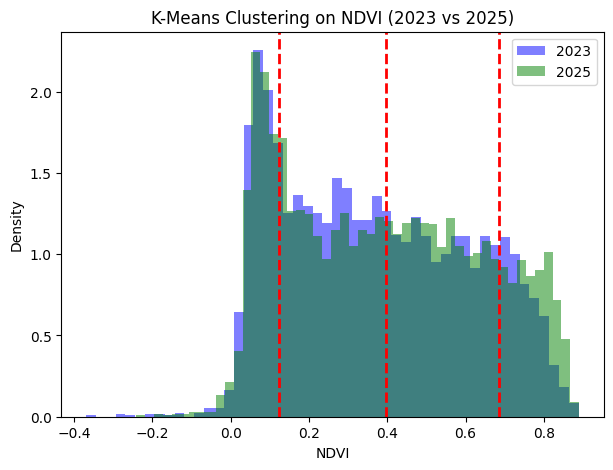

In [40]:
plt.figure(figsize=(7,5))

# Histograms
plt.hist(vals_2023, bins=50, alpha=0.5, label="2023", color="blue", density=True)
plt.hist(vals_2025, bins=50, alpha=0.5, label="2025", color="green", density=True)

# Cluster centers
for center in sorted(kmeans.cluster_centers_.flatten()):
    plt.axvline(center, color="red", linestyle="--", linewidth=2)

plt.xlabel("NDVI")
plt.ylabel("Density")
plt.title("K-Means Clustering on NDVI (2023 vs 2025)")
plt.legend()
plt.show()
